In [1]:
#TODO: I want attrs to propagate through...need to start in the first step though...

In [2]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [3]:
# !pip install coiled

In [4]:
# import coiled
# cluster = coiled.Cluster(n_workers=10, worker_vm_types= 'n2d-highmem-2', spot_policy='spot_with_fallback')
# client = cluster.get_client()

In [5]:
# !pip install coiled

In [6]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()
print('setting up new cluster')

options = gateway.cluster_options()
# options.worker_memory = 115 # Have been able to get 115 so far.
# options.worker_cores = 15 # somehow I can not get all 16 cores here....  Need to understand these limits and how to split up a node properly.

options.worker_memory = 7
options.worker_cores = 1 # more conservative request. Can I get more workers?

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.scale(150)
# cluster.adapt(5, 350) #ADAPT IS ROYALLY FING ME HERE BOTH WITH COILED AND DG...
# cluster.adapt(3, 100)
# cluster.adapt(50, 600)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.41380d1c5ee64763b880b3c0e09fe316/status,


In [8]:
# Reproducibility info
import os
os.environ['JUPYTER_IMAGE']

'pangeo/pangeo-notebook:2023.08.29'

In [9]:
import gcsfs
import xarray as xr
import numpy as np
from scale_aware_air_sea.utils import filter_inputs_dataset, to_zarr_split, open_zarr, weighted_coarsen, maybe_save_and_reload
from scale_aware_air_sea.parameters import get_params

In [10]:
fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v1.0.0', test=False)
models = params['paths'].keys()

In [11]:
def small_scale_decomposition(ds: xr.Dataset) -> xr.Dataset:
    """This encodes a lot of the theoretical discussions I had with Dhruv"""
    
    # FIXME: This attribute should be set in the smoothing/coarsening steps.
    method = ds.attrs.get('smooth_method', None)
    if method is None or method not in ['coarse', 'filter']:
        raise ValueError(
            "Input dataset needs to contain a dataset attribute `smooth_method` indicating ",
            "if the dataset was filtered (value='filter') or coarsened (value='coarse')."
        )
    
    def filt(ds: xr.Dataset) -> xr.Dataset:
        """Utility function to reapply filtering as smoother"""
        return filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], params['filter_scale']) # TODO: should I pass the params in a better way? Maybe create a filtering class?
    
    # NOTE: We don't need this for coarsening, because that is a reynolds operator
    
    tdict = {}
    
    # Q_H (AB) - high resolution input
    if method == 'filter':
        tdict['Q_H'] = ds.sel(smoothing='smooth_none')
        tdict['Q_H_bar'] = filt(tdict['Q_H'])
    elif method == 'coarse':
        tdict['Q_H_bar'] = ds.sel(smoothing='smooth_none')
        
    # Q_L low resolution input
    if method == 'filter': 
        tdict['Q_L'] = ds.sel(smoothing='smooth_all')
        tdict['Q_L_bar'] = filt(tdict['Q_L'])
        tdict['Q_L_prime'] = tdict['Q_L'] - tdict['Q_L_bar'] # TODO: I could potentially compute this on the fly...
    elif method == 'coarse':
        tdict['Q_L_bar'] = ds.sel(smoothing='smooth_all')
        
    
    # Inferred Small scale
    if method == 'filter':
        tdict['Q_star'] = tdict['Q_H_bar'] - tdict['Q_L']
        tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
    elif method == 'coarse':
        tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
        
    # mixed low resolution input (filtered only)
    if method == 'filter':
        if 'smooth_vel_tracer_ocean' in ds.smoothing and 'smooth_vel_tracer_atmos' in ds.smoothing:
            tdict['Q_L_ocean'] = ds.sel(smoothing='smooth_vel_tracer_ocean')
            tdict['Q_L_ocean_bar'] = filt(tdict['Q_L_ocean'])

            tdict['Q_L_atmos'] = ds.sel(smoothing='smooth_vel_tracer_atmos')
            tdict['Q_L_atmos_bar'] = filt(tdict['Q_L_atmos'])

            tdict['Q_star_star_ocean'] = tdict['Q_H_bar'] - tdict['Q_L_ocean_bar']
            tdict['Q_star_star_atmos'] = tdict['Q_H_bar'] - tdict['Q_L_atmos_bar']

        if 'smooth_vel' in ds.smoothing and 'smooth_tracer' in ds.smoothing:
            tdict['Q_L_vel'] = ds.sel(smoothing='smooth_vel')
            tdict['Q_L_vel_bar'] = filt(tdict['Q_L_vel'])

            tdict['Q_L_tracer'] = ds.sel(smoothing='smooth_tracer')
            tdict['Q_L_tracer_bar'] = filt(tdict['Q_L_tracer'])

            tdict['Q_star_star_vel'] = tdict['Q_H_bar'] - tdict['Q_L_vel_bar']
            tdict['Q_star_star_tracer'] = tdict['Q_H_bar'] - tdict['Q_L_tracer_bar']
    
    # concat into a single dataset
    datasets = [tdict[t].assign_coords(term=t).drop([dvar for dvar in ['smoothing'] if dvar in tdict[t]]) for t in tdict.keys()]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds.attrs
    return ds_out

In [12]:
# prototype with one single dataset (this should be replicable with others)
output_dict = {}

dataset_spec = 'prod'
model = 'CM26'
for model in ['CESM', 'CM26']:
    print(f"{model =}")
    model_dict = {}
    for dataset_spec in ['prod', 'appendix']:
        print(f"{dataset_spec =}")
        dataset_spec_dict = {}
        for time_spec in ['daily', 'mean']:
            print(f"{time_spec =}")
            flux_data = {
                s:open_zarr(
                    params['paths'][model][s+'_fluxes_'+dataset_spec]
                ).squeeze().assign_attrs({'smooth_method':s}) for s in ['filter', 'coarse'] #FIXME: the attributes should be assigned during writing!
            }
            
            if time_spec == 'mean':
                flux_data = {s:ds.mean('time', keep_attrs=True) for s,ds in flux_data.items()}
            
            small_scale = {s:small_scale_decomposition(ds) for s,ds in flux_data.items()}

            # cut output terms for production daily!
            if time_spec == 'daily':

                if dataset_spec == 'prod':
                    keep_terms = ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos']
                elif dataset_spec == 'appendix':
                    keep_terms = ['Q_star', 'Q_star_star', 'Q_star_star_ocean',
                     'Q_star_star_atmos','Q_star_star_vel', 'Q_star_star_tracer']

                small_scale = {s:ds.sel(term=[t for t in keep_terms if t in ds.term]) for s,ds in small_scale.items()}
        
            dataset_spec_dict[time_spec] = small_scale
        
        model_dict[dataset_spec] = dataset_spec_dict
    output_dict[model] = model_dict

model ='CESM'
dataset_spec ='prod'
time_spec ='daily'


KeyError: '.zmetadata'

## just get something written out for the paper

> Check carefully how much the values are different below. Maybe a few % difference are not worth the unbelievable effort of filtering this again.

In [15]:
cluster.scale(350)

In [ ]:
# Save out the mean decomposition (relatively cheap) for both variants, 
# But for now only save the daily resolution out for the appendix datasets
# TBD if this is accurate enough.
for time_spec, variants in [('mean', ['prod', 'appendix']), ('daily', ['appendix'])]:
    for variant in variants:
        for s in ['filter', 'coarse']:
            for model in models:
                out_path = params['paths'][model][f'{s}_decomposition_{time_spec}_{variant}']
                print(out_path)
                ds = output_dict[model][variant][time_spec][s]
                # ds_reloaded = maybe_save_and_reload(ds, out_path)

In [ ]:
cluster.scale(15)

In [11]:
# import gcsfs
# fs = gcsfs.GCSFileSystem()
# fs.rm("gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/results/CM26_fluxes_filter_decomposed_mean.zarr", recursive=True)

## Check that decomposition is linear
It is not in the presence of the ice mask. I need to turn this into a reproducible issue/appendix. Ideally I can show this from synthetic data...

Steps to reproduce from above: 
- reduce the number of timesteps.

In [37]:
cluster.adapt(minimum=450, maximum=450, interval='2m')

2023-10-25 04:18:24,198 - distributed.deploy.adaptive_core - INFO - Adaptive stop
2023-10-25 04:18:24,199 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=450 maximum=450
2023-10-25 04:18:24,231 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [40]:
# # uncomment to overwrite
# fs.rm('gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing', recursive=True)

flux_data = {
    s:open_zarr(
        params['paths']['CESM'][s+'_fluxes_appendix']
    ).squeeze().assign_attrs({'smooth_method':s}) for s in ['filter', 'coarse']
}
flux_data_cut = {s:ds.isel(time=slice(0, 180)) for s, ds in flux_data.items()}
small_scale_from_mean = {s:small_scale_decomposition(ds.mean('time', keep_attrs=True)) for s,ds in flux_data_cut.items()}
mean_from_small_scale = {s:small_scale_decomposition(ds).mean('time') for s,ds in flux_data_cut.items()}

# save to temp store
small_scale_from_mean = {
    s:maybe_save_and_reload(ds, f'gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/small_scale_from_mean_{s}') for s,ds in small_scale_from_mean.items()
}
mean_from_small_scale = {
    s:maybe_save_and_reload(ds, f'gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/mean_from_small_scale_{s}') for s,ds in mean_from_small_scale.items()
}

Reload dataset from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/small_scale_from_mean_filter
Reload dataset from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/small_scale_from_mean_coarse
Reload dataset from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/mean_from_small_scale_filter
Saving the dataset to zarr at gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/mean_from_small_scale_coarse
Reload dataset from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/testing/mean_from_small_scale_coarse


In [ ]:
cluster.close()

In [49]:
from distributed import Client
client = Client()

In [52]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42305,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: 2 minutes ago,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:46545,Total threads: 4
Dashboard: /user/jbusecke/proxy/35107/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:39339,


In [50]:
test = abs(small_scale_from_mean['filter'] - mean_from_small_scale['filter']) / mean_from_small_scale['filter'] *100
test

<xarray.Dataset>
Dimensions:             (yt_ocean: 2400, xt_ocean: 3600, algo: 2, term: 19)
Coordinates: (12/44)
    ANGLET              (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    DXT                 (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    DYT                 (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    HT                  (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    KMT                 (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    REGION_MASK         (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    ...                  ...
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
  * term                (term) <U18 'Q_H' 'Q_H_bar' ... 'Q_star_star_tracer'
    vonkar              float64 0.0
  * xt_ocean            (xt_ocean) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * yt_ocean            (yt_ocean) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Data variables:
    qh                  (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
    ql                  (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>

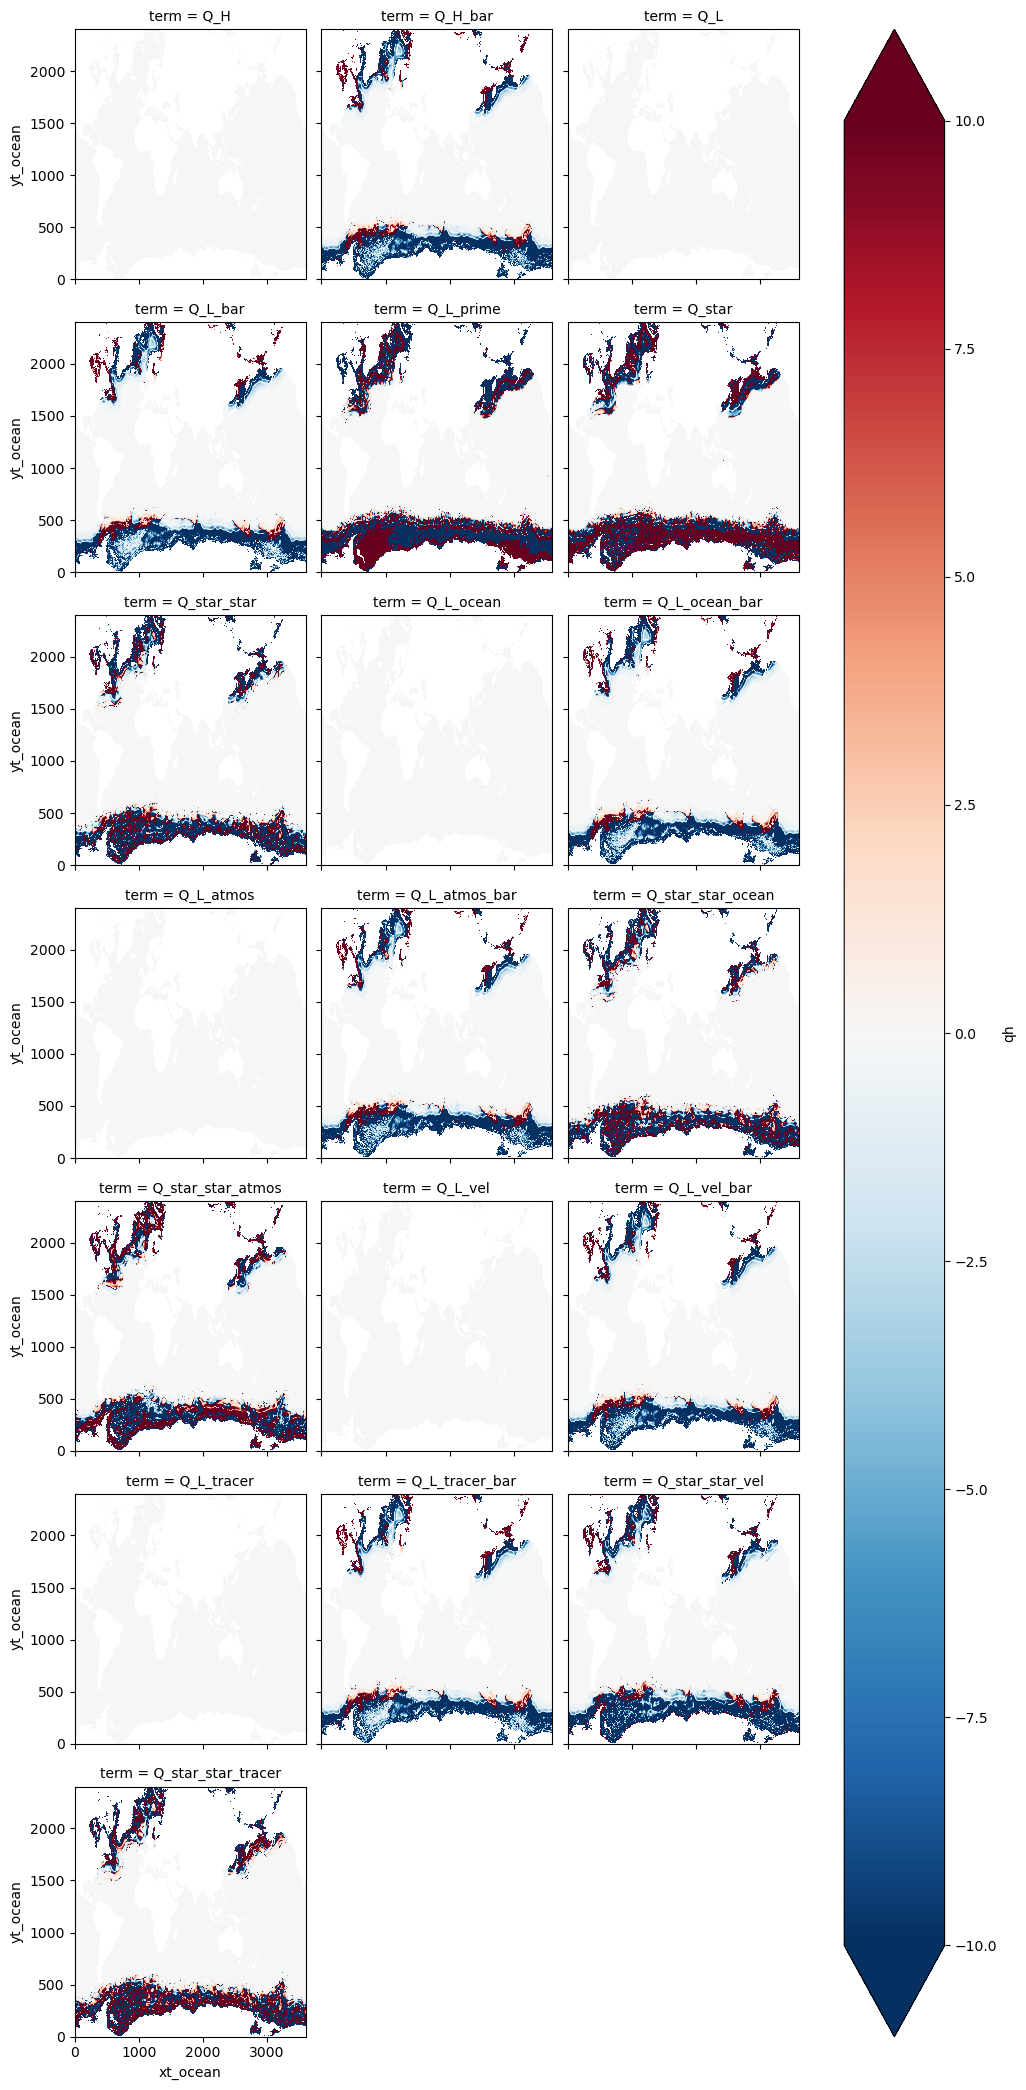

In [59]:
test.qh.isel(algo=0).plot(col='term', col_wrap=3, vmax=10)

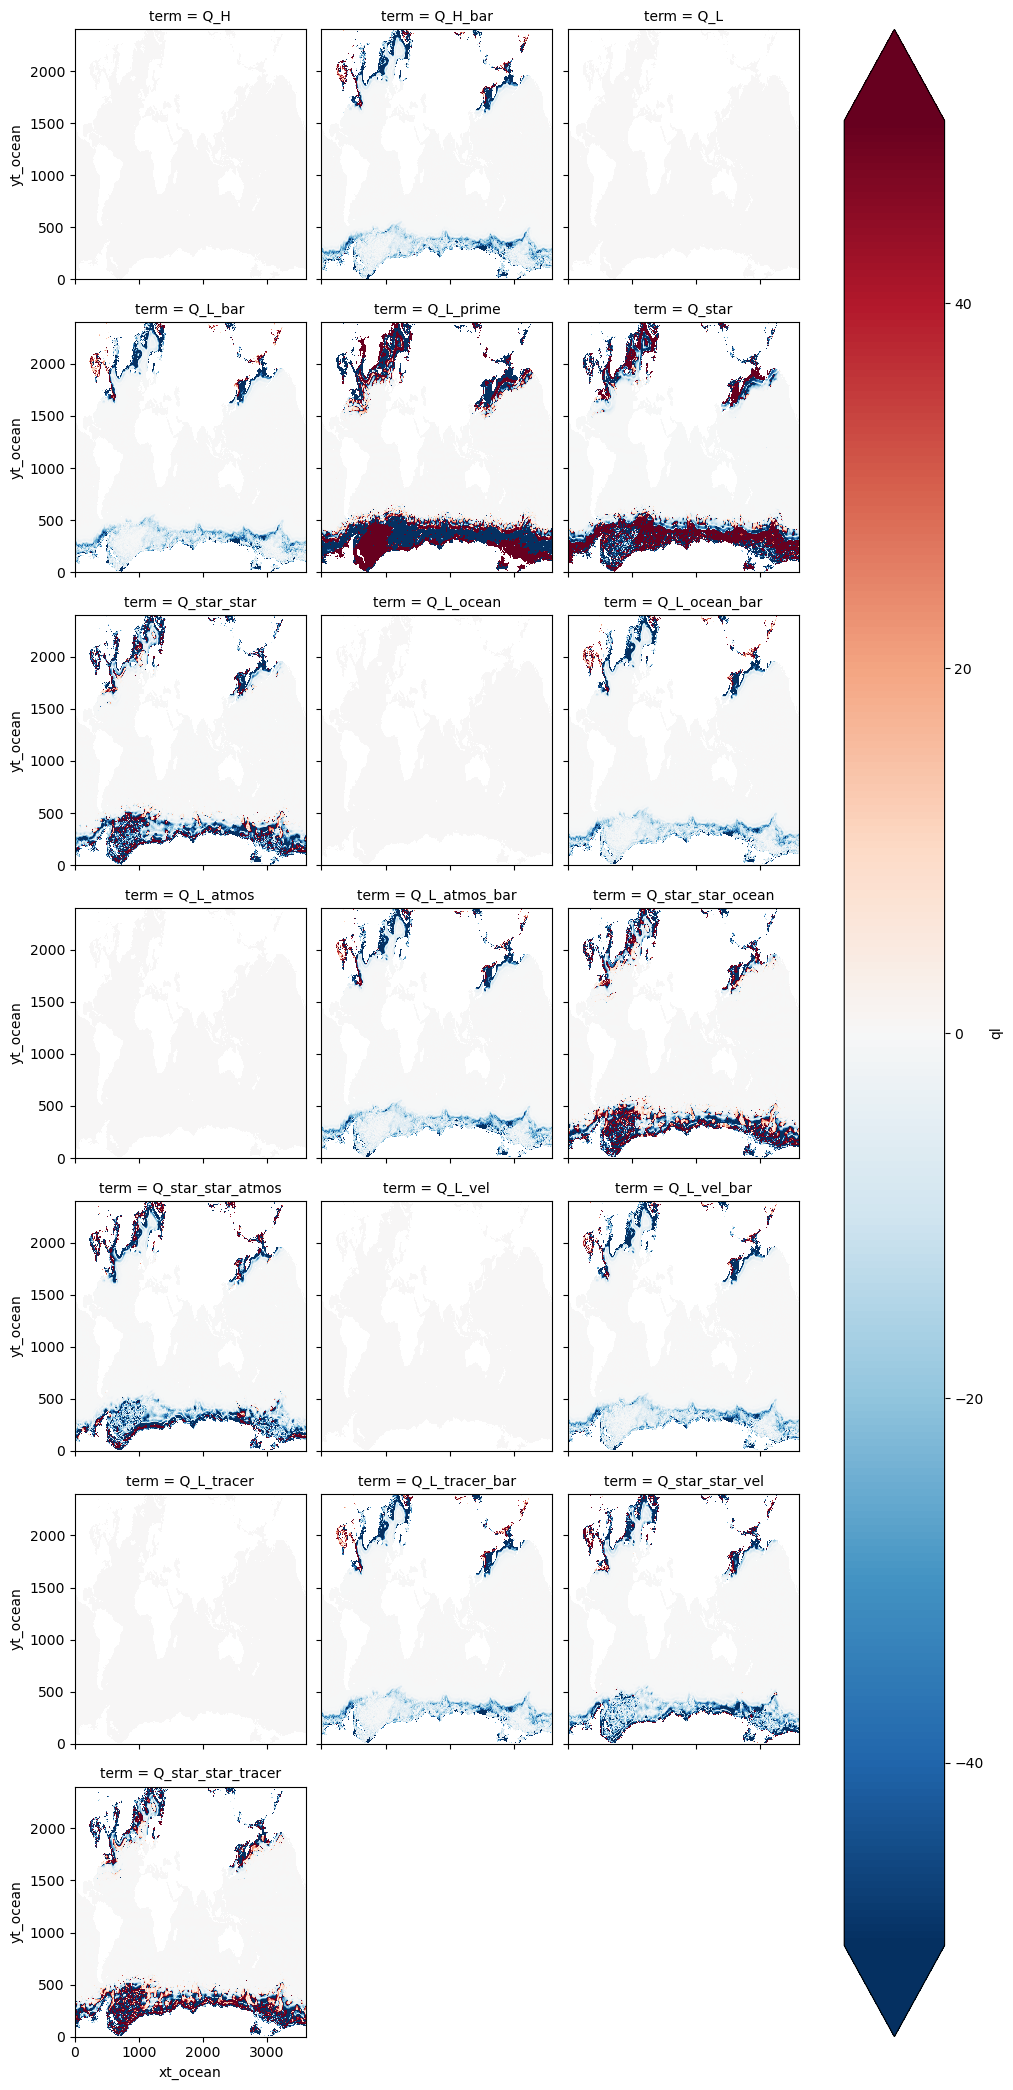

In [58]:
test.ql.isel(algo=0).plot(col='term', col_wrap=3, vmax=50)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(3,1,1)
small_scale_from_mean['filter'].isel(algo=0).ql.sel(term='Q_star_star').plot(vmax=50)

plt.subplot(3,1,2)
mean_from_small_scale['filter'].isel(algo=0).ql.sel(term='Q_star_star').plot(vmax=50)

plt.subplot(3,1,3)
(mean_from_small_scale['filter'].isel(algo=0).ql.sel(term='Q_star_star') - small_scale_from_mean['filter'].isel(algo=0).ql.sel(term='Q_star_star')).plot(vmax=5)

In [ ]:
xr.testing.assert_allclose(mean_from_small_scale['filter'], small_scale_from_mean['filter'])

In [ ]:
xr.testing.assert_allclose(mean_from_small_scale['coarse'], small_scale_from_mean['coarse'])

In [ ]:
test_coarse = abs(small_scale_from_mean['coarse'] - mean_from_small_scale['coarse']) / mean_from_small_scale['coarse'] *100
test_coarse

In [ ]:
test_coarse.qh.plot(col='term', col_wrap=3, robust=True)

In [89]:
# # new scale separation
# def decomposition_filter(ds):
#     """Decomposing filtered flux outputs into different terms to evaluate"""
#     def filt(ds):
#         return filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], params['filter_scale'])
    
#     # all possible terms: ['Q_H', 'Q_H_bar', 'Q_L', 'Q_L_bar']
    
#     # ['Q_star', `Q_star_star`, 'Q_star_star_ocean', 'Q_star_star_atmos']
    
#     tdict = {}
    
#     # Q_H (AB) - high resolution input
#     tdict['Q_H'] = ds.sel(smoothing='smooth_none')
#     tdict['Q_H_bar'] = filt(tdict['Q_H'])
    
#     # Q_L low resolution input
#     tdict['Q_L'] = ds.sel(smoothing='smooth_all')
#     tdict['Q_L_bar'] = filt(tdict['Q_L'])
#     tdict['Q_L_prime'] = tdict['Q_L'] - tdict['Q_L_bar'] # TODO: I could potentially compute this on the fly...
    
#     # Inferred Small scale
#     tdict['Q_star'] = tdict['Q_H_bar'] - tdict['Q_L']
#     tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
    
#     # mixed low resolution input
#     tdict['Q_L_ocean'] = ds.sel(smoothing='smooth_vel_tracer_ocean')
#     tdict['Q_L_ocean_bar'] = filt(tdict['Q_L_ocean'])
    
#     tdict['Q_L_atmos'] = ds.sel(smoothing='smooth_vel_tracer_atmos')
#     tdict['Q_L_atmos_bar'] = filt(tdict['Q_L_atmos'])
        
#     tdict['Q_star_star_ocean'] = tdict['Q_H_bar'] - tdict['Q_L_ocean_bar']
#     tdict['Q_star_star_atmos'] = tdict['Q_H_bar'] - tdict['Q_L_atmos_bar']
    
#     if 'smooth_vel' in ds.smoothing and 'smooth_tracer' in ds.smoothing:
#         tdict['Q_L_vel'] = ds.sel(smoothing='smooth_vel')
#         tdict['Q_L_vel_bar'] = filt(tdict['Q_L_vel'])

#         tdict['Q_L_tracer'] = ds.sel(smoothing='smooth_tracer')
#         tdict['Q_L_tracer_bar'] = filt(tdict['Q_L_tracer'])
    
#         tdict['Q_star_star_vel'] = tdict['Q_H_bar'] - tdict['Q_L_vel_bar']
#         tdict['Q_star_star_tracer'] = tdict['Q_H_bar'] - tdict['Q_L_tracer_bar']
    
#     # concat into a single dataset
#     datasets = [tdict[t].assign_coords(term=t).drop([dvar for dvar in ['smoothing'] if dvar in tdict[t]]) for t in tdict.keys()]
#     ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
#     ds_out.attrs = ds.attrs
#     return ds_out


# def decomposition_coarse(ds_filter, ds_coarse):
#     def smooth(ds):
#         return weighted_coarsen(
#             ds, 
#             {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
#             'area_t'
#         )
    
#     decomp = {}
#     # Q_H (AB) - high resolution input
#     # Q_H = ds_filter.sel(smoothing='smooth_none') # dont include in dict, because it has different size
#     # decomp['Q_H_bar'] = smooth(Q_H)
#     # This output is already included in the new store
#     decomp['Q_H_bar'] = ds_coarse.sel(smoothing='smooth_none')
    
#     # Q_L low resolution input
#     decomp['Q_L'] = ds_coarse.sel(smoothing='smooth_all')

#     # Inferred Small scale (Q_star=Q_star_star in this case, renaming just for convinence).
#     decomp['Q_star_star'] = decomp['Q_H_bar'] - decomp['Q_L']
    
    
#     # concat into a single dataset
#     datasets = [ds.drop([dvar for dvar in ['smoothing'] if dvar in ds]).assign_coords(term=k) for k,ds in decomp.items()]
#     ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
#     ds_out.attrs = ds_coarse.attrs
#     return ds_out

## Long term mean decompositions (do I need these or can I just do e.g. a monthly one?)

In [13]:
def long_term_mean(ddict: dict[str, dict[str, xr.Dataset]]):
    return {k: {model: ds.mean('time').persist() for model,ds in mdict.items()} for k, mdict in ddict.items()}

# def monthly_mean(ddict: dict[str, dict[str, xr.Dataset]]):
#     return {k: {model: ds.mean('time').persist() for model,ds in mdict.items()} for k, mdict in ddata.items()}

In [16]:
long_term_mean_filter = long_term_mean(flux_data_filter)
long_term_mean_coarse = long_term_mean(flux_data_coarse)

def decomp_wrapper(ddict_filtered, ddict_coarse):
    decomp_filter = {}

# long term decomposition
long_term_decomp_filter = {k: {model: decomposition_filter(ds) for model,ds in mdict.items()} for k, mdict in long_term_mean_filter.items()}
long_term_decomp_coarse = {k: {model: decomposition_coarse(long,ds) for model,ds in mdict.items()} for k, mdict in long_term_mean_coarse.items()}


KeyboardInterrupt



In [32]:
terms = ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_vel', 'Q_star_star_tracer']
long_term_decomp = {k: {model: decomposition_filter(ds) if 'filter' in k else decomposition_coarse(ds) for model,ds in mdict.items()} for k, mdict in flux_data.items()}

TypeError: decomposition_coarse() missing 1 required positional argument: 'ds_coarse'

2023-10-23 22:18:22,006 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1007)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 192, in _handle_events
    handler_func(fileobj, events)

In [20]:
# ds_filter_fluxes_prod_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_filter_fluxes_prod_dict.items()}
ds_filter_fluxes_appendix_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_filter_fluxes_appendix_dict.items()}
# ds_coarse_fluxes_prod_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_coarse_fluxes_prod_dict.items()}
# ds_coarse_fluxes_appendix_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_coarse_fluxes_appendix_dict.items()}

In [21]:
ds_filter_fluxes_appendix_mean_dict

{'CM26': <xarray.Dataset>
 Dimensions:    (algo: 5, yt_ocean: 2700, xt_ocean: 3600, smoothing: 6)
 Coordinates:
   * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
     area_t     (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     dxt        (yt_ocean, xt_ocean) float64 1.719e+03 1.719e+03 ... 4.697e+03
     dyt        (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 23.38 7.804
     geolat_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     geolon_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     ht         (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     kmt        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
   * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
     wet        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
   * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
   * yt_oc

In [22]:
# terms = ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos']
# ds_filter_decomp_prod_mean_dict = {model: decomposition_filter(ds).sel(term=terms) for model,ds in ds_filter_fluxes_prod_mean_dict.items()}

terms = ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_vel', 'Q_star_star_tracer']
ds_filter_decomp_appendix_mean_dict = {model: decomposition_filter(ds).sel(term=terms) for model,ds in ds_filter_fluxes_appendix_mean_dict.items()}


KeyboardInterrupt



In [ ]:
ds_filter_decomp_appendix_mean_dict['CESM'].isel(algo=0).to_array()

In [ ]:
# ds_filter_decomp_prod_mean_dict['CESM']#[terms]
da_plot = ds_filter_decomp_appendix_mean_dict['CESM'].isel(algo=0).to_array().load()

In [ ]:
da_plot.plot(col='variable', row='term')#[terms]

In [ ]:
ds_filter_decomp_appendix_mean_dict['CM26'].isel(algo=0).to_array().plot(col='variable', row='term')#[terms]

## Pick up here: 
- Hmm the above does not work nicely... the filtering is not executing?
- Quickly check the long term averages if they look ok
    - CESM looks similar to CM26?
    - Tracer/Vel looks similar to ocean/atmos?
- Decide what output terms/frequencies we actually need
    - Maybe just test that the decomposition of the mean = mean of the decomposition
        - Oh that might not be the case because of the filtering.....
    - Then I can just write out monthly data for prod and daily for appendix? ... and average them later
- Write them all out
- Thats it!

In [16]:
# long terms means of both
# ds_coarse_fluxes_mean = ds_coarse_fluxes.mean('time')
ds_filter_fluxes_mean = ds_filter_fluxes.mean('time')

In [17]:
# persist the means to reduce computation later
# ds_coarse_fluxes_mean = ds_coarse_fluxes_mean.persist()
ds_filter_fluxes_mean = ds_filter_fluxes_mean.persist()

In [18]:
ds_filter_fluxes_monthly = ds_filter_fluxes.resample(time='1MS').mean()
# ds_coarse_fluxes_monthly = ds_coarse_fluxes.resample(time='1MS').mean()

In [19]:
filter_decomp_mean = decomposition_filter(
    ds_filter_fluxes_mean,
    ['Q_star', 'Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_vel', 'Q_star_star_tracer']
)

In [20]:
# coarse_decomp_mean = decomposition_coarse(ds_filter_fluxes_mean, ds_coarse_fluxes_mean)
# # Some checks in the weighted coarsen trigger computation for the first slice (which here is the full dataset). 
# # I persisted both above to only do that once.
# coarse_decomp_mean

In [21]:
# I have an appendix array with all algos, lets save some time and space and only use our reference algo
filter_decomp_monthly = decomposition_filter(ds_filter_fluxes_monthly.sel(algo=primary_algo), ['Q_star_star','Q_H_bar'])

In [22]:
# coarse_decomp_monthly = decomposition_coarse(ds_filter_fluxes_monthly, ds_coarse_fluxes_monthly)

In [23]:
# coarse_decomp_daily = decomposition_coarse(ds_filter_fluxes.sel(algo=primary_algo), ds_coarse_fluxes.sel(algo=primary_algo))
filter_decomp_daily = decomposition_filter(
    ds_filter_fluxes.sel(algo=primary_algo), 
    ['Q_star_star']
)

In [24]:
# 2 year only but with all algos for the appendix
filter_decomp_daily_appendix = decomposition_filter(
    ds_filter_fluxes.sel(time=slice('0181-01-01', '0183-01-01')), 
    ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos'] # for the case_study.ipynb
)
filter_decomp_daily_appendix

<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 2700, xt_ocean: 3600, time: 731, term: 3)
Coordinates: (12/13)
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...        ...
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-01 12:00:00 ... 0183-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * term      (term) <U17 'Q_star_star' 'Q_star_star_ocean' 'Q_star_star_atmos'
Data variables:
    ql        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

### Save out all decompositions

In [25]:
# fs.rm(mapper_filter_flux_decomposition_mean.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_mean.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_daily.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_daily_appendix.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_daily.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_monthly.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_monthly.root, recursive=True)

In [26]:
for ds, mapper, msg in [
    # (filter_decomp_mean, mapper_filter_flux_decomposition_mean, 'Long Term Mean Filter'),
    # (coarse_decomp_mean, mapper_coarse_flux_decomposition_mean, 'Long Term Mean Coarse'),
    # (filter_decomp_monthly, mapper_filter_flux_decomposition_monthly, 'Montlhy Filter'),
    # (coarse_decomp_monthly, mapper_coarse_flux_decomposition_monthly, 'Montlhy Coarse'),
    # (filter_decomp_daily_appendix, mapper_filter_flux_decomposition_daily_appendix, 'Daily Filter (all algos for appendix)'),
    # (filter_decomp_daily, mapper_filter_flux_decomposition_daily, 'Daily Filter'),
    # (coarse_decomp_daily, mapper_coarse_flux_decomposition_daily, 'Daily Coarse'),
]:
    # datasets 'tests'
    assert 'geolon_t' in ds
    assert 'geolat_t' in ds
    
    
    # cluster.scale(200) # if some workers got lost? This might not be the best place to reset this...
    for va in ds.variables:
        if 'chunks' in ds[va].encoding.keys():
            # print(va)
            del ds[va].encoding['chunks']

    print(f"Saving {msg}: {ds.nbytes/1e9}GB")
    if 'time' in ds.dims:
        to_zarr_split(
            ds,
            mapper,
            # split_interval=50 if 'algo' in ds.dims else 150
            split_interval=150 if 'algo' in ds.dims else 450
            # split_interval=60 # less memory pressure on the scheduler. Set back to 60 when using dask-gateway...
        )
    else:
        ds.to_zarr(mapper)

Saving Long Term Mean Filter: 2.799410968GB
Saving Montlhy Filter: 37.79141244GB
Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_filter_decomposed_monthly_v0.7.0.zarr ...


2023-03-20 19:13:04,138 - distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('store-map-004067c6f484f93fa57dec3f20a51952', 0, 22, 0, 0)": (), "('store-map-004067c6f484f93fa57dec3f20a51952', 0, 229, 0, 0)": ()}


0it [00:00, ?it/s]

In [5]:
ds = open_zarr(mapper_filter_flux_decomposition_daily)

In [9]:
ds.qh.isel(xt_ocean=2000, yt_ocean=1000).plot()


KeyboardInterrupt



In [13]:
# cluster.shutdown()